In [1]:
import pydicom
from scipy.optimize import least_squares, minimize

from data_structures.ct_image import CTImage
from utils import *

In [2]:
reference_image_path = "data_2/Project/icbm_avg_152_t1_tal_nlin_symmetric_VI.dcm"
patient_image_path = "data_2/Project/RM_Brain_3D-SPGR/"

In [3]:
reference_image = pydicom.dcmread(reference_image_path)
reference_image.pixel_array.shape

(193, 229, 193)

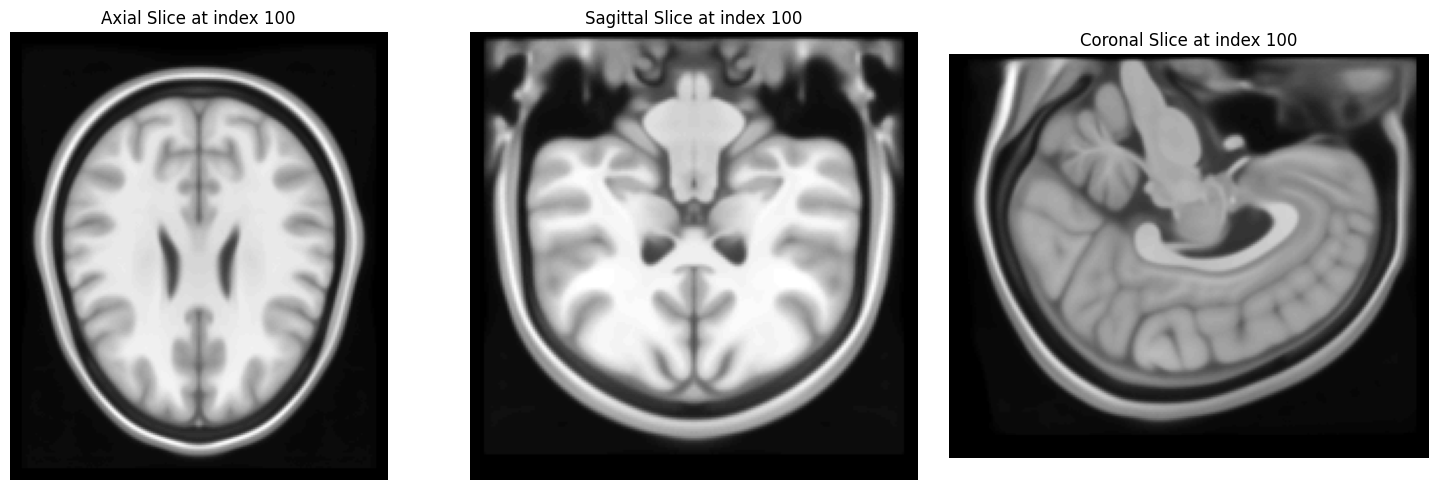

In [4]:
visualize_slices(reference_image.pixel_array, 100, 100, 100)

In [5]:
patient_image = CTImage()
patient_image.load_data(patient_image_path)
patient_image.make_3d_array()

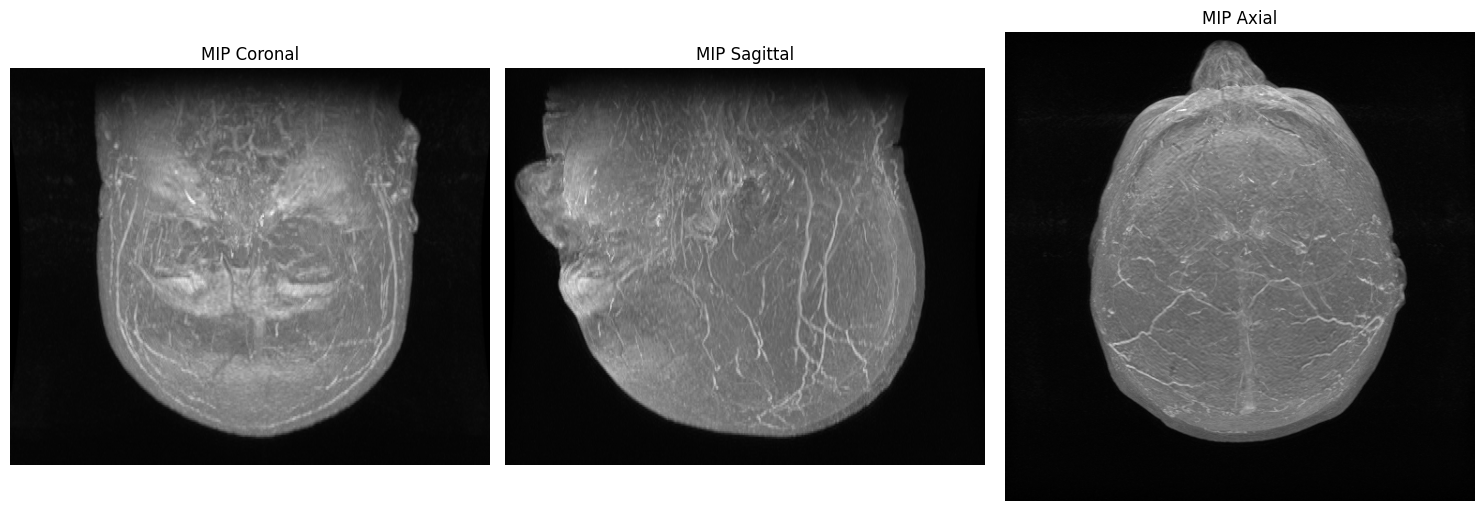

In [6]:
patient_image.visualize_all_projections_mip()

(212, 512, 512)


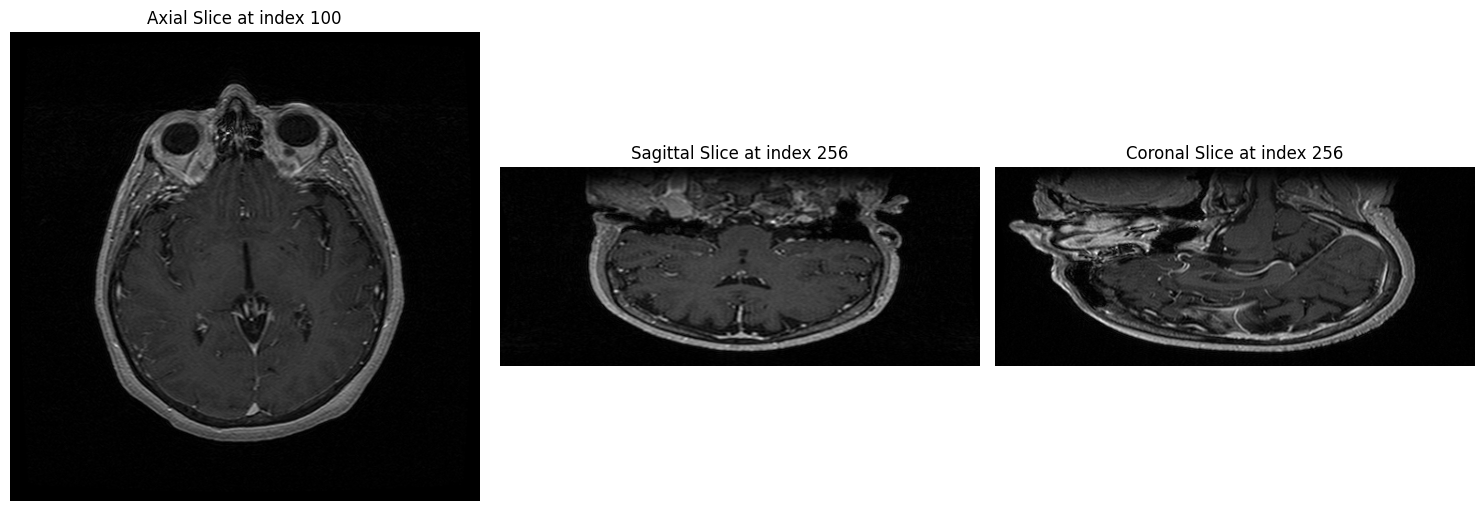

In [7]:
print(patient_image.pixel_array.shape)
patient_image.visualize_slices(100, 256, 256)

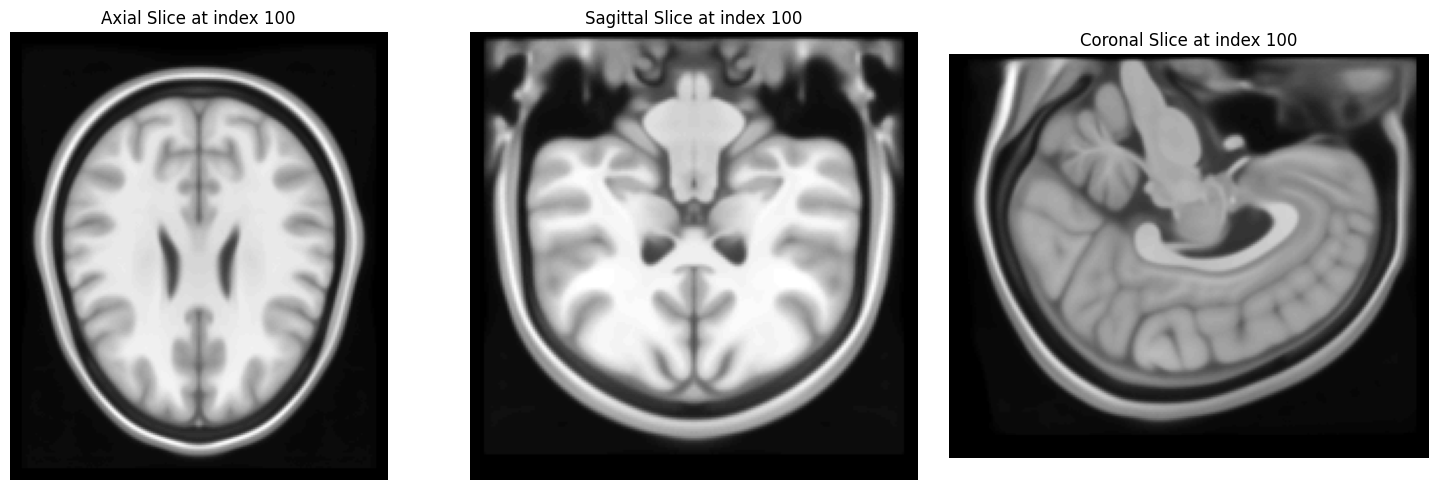

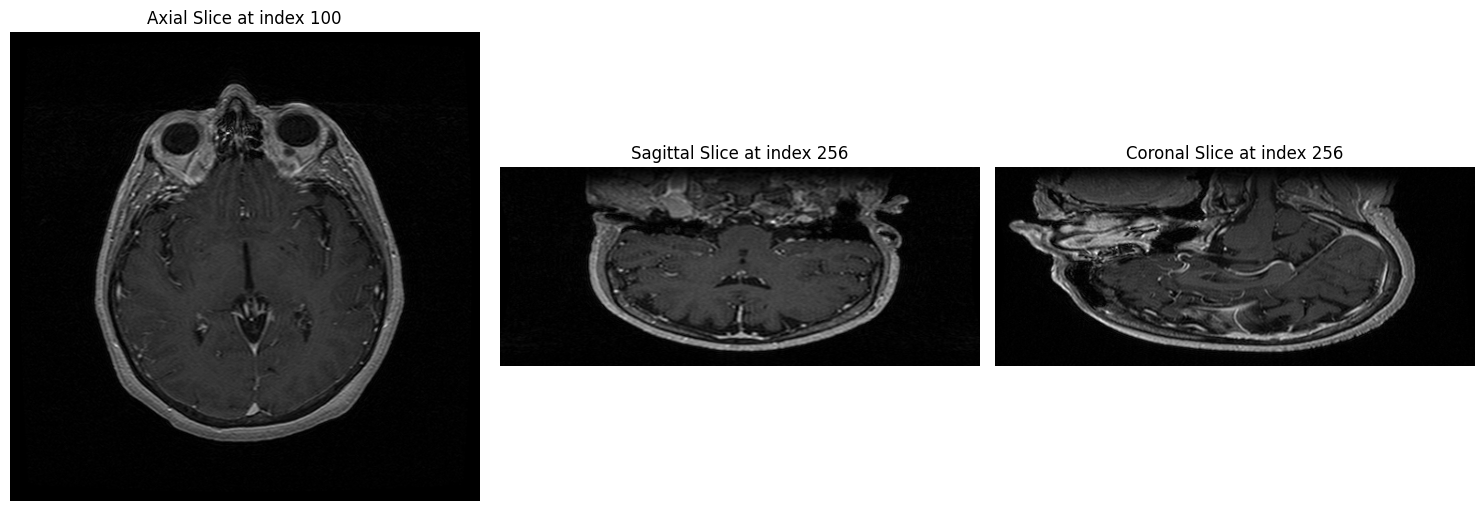

In [8]:
visualize_slices(reference_image.pixel_array, 100, 100, 100)
patient_image.visualize_slices(100, 256, 256)

In [9]:
patient_image.pixel_array = rotate_on_axial_plane(patient_image.pixel_array, 180)

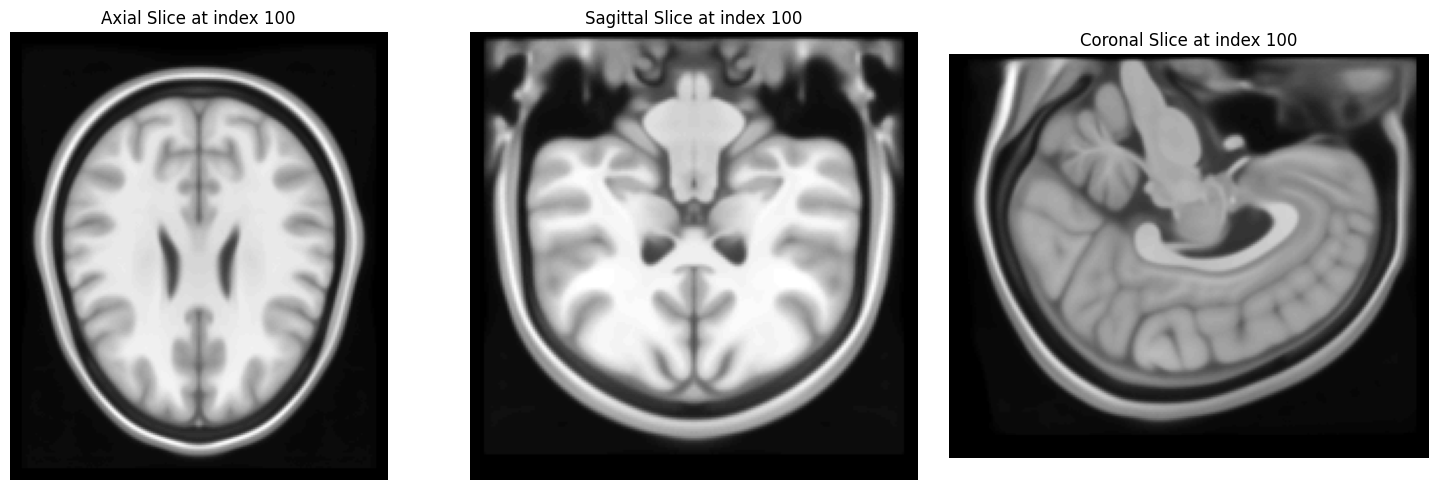

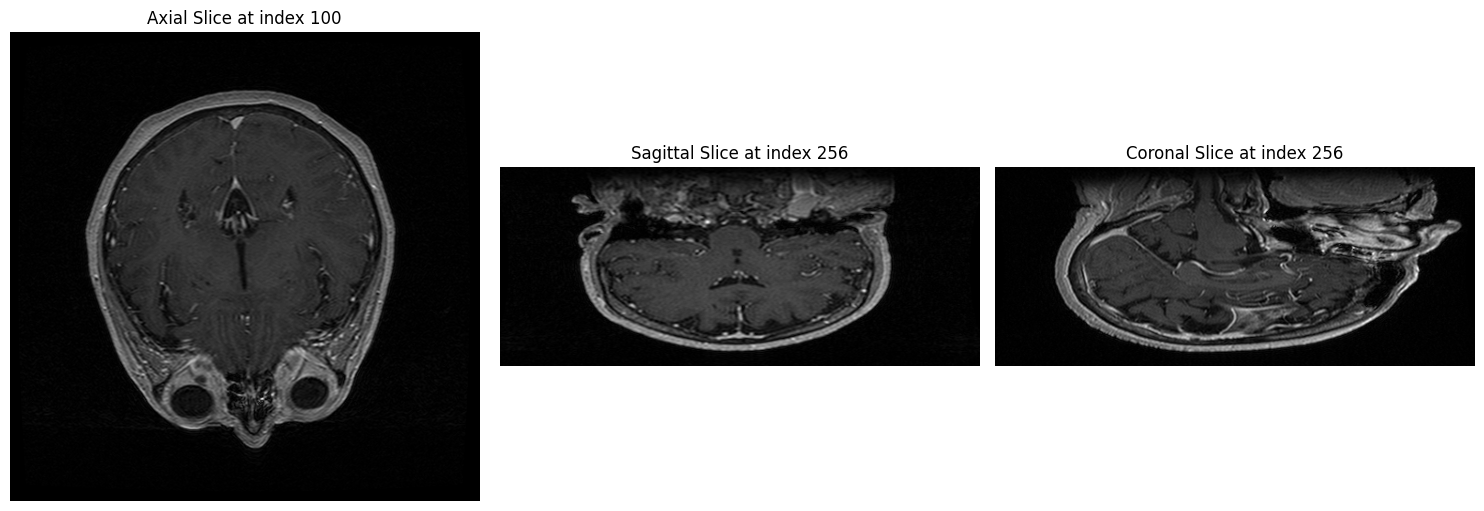

In [10]:
visualize_slices(reference_image.pixel_array, 100, 100, 100)
patient_image.visualize_slices(100, 256, 256)

In [11]:
print(patient_image.pixel_array.shape)
print(reference_image.pixel_array.shape)

(212, 512, 512)
(193, 229, 193)


In [12]:
# Pixel Spacing
patient_pixel_spacing = patient_image.slices[0].pixel_spacing[0] #read from dicom header
scaling_factors = (1, 1/patient_pixel_spacing, 1/patient_pixel_spacing)
reference_zoomed = scipy.ndimage.zoom(reference_image.pixel_array, scaling_factors, order=1)

In [13]:
reference_zoomed = pad_image(reference_zoomed, patient_image.pixel_array.shape)
reference_zoomed.shape

(212, 512, 512)

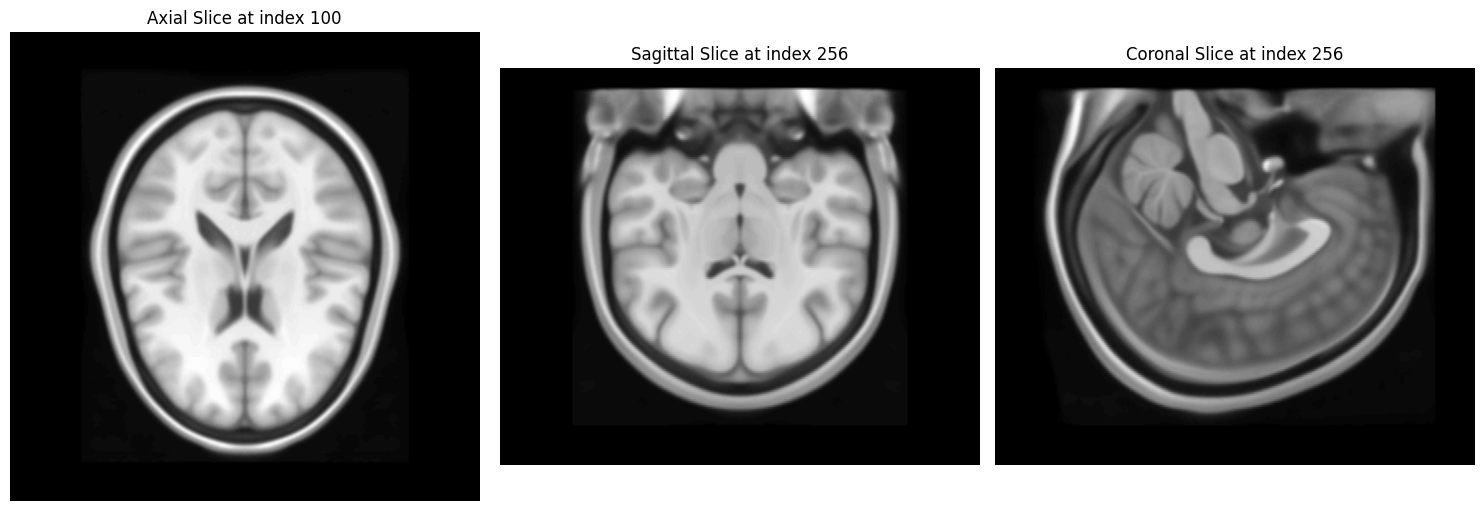

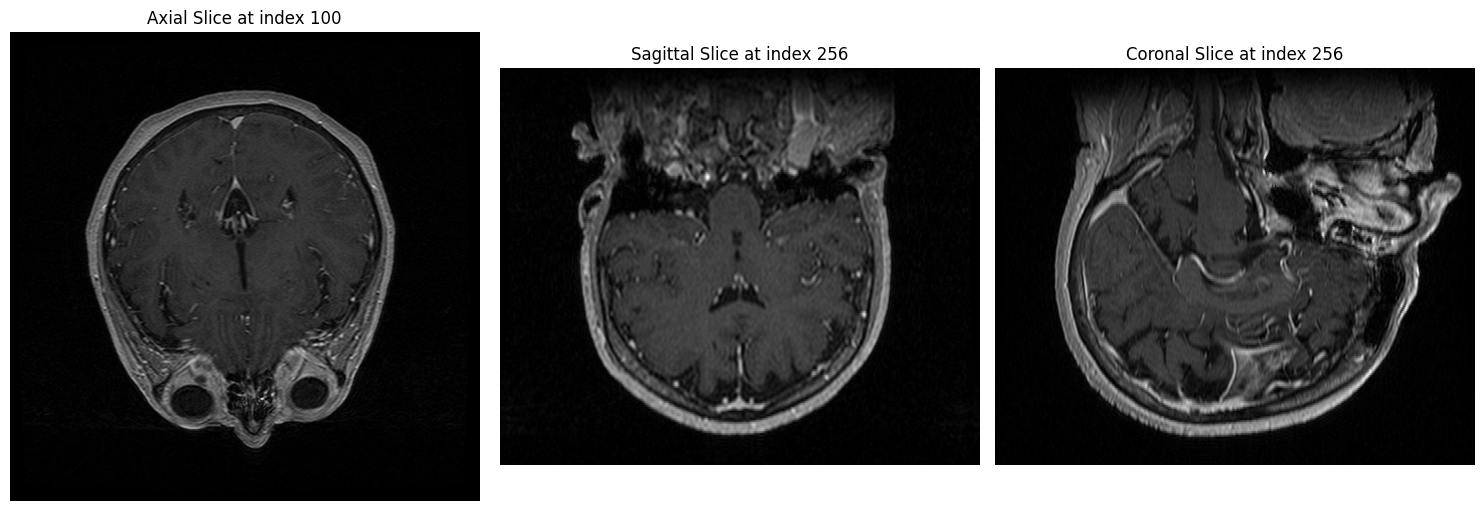

In [14]:
visualize_slices(reference_zoomed, 100, 256, 256, aspect=2)
patient_image.visualize_slices(100, 256, 256, aspect=2)

In [15]:
def translate_image(image, translations):
    # Use scipy.ndimage.shift for translation without wrap-around
    translated_image = scipy.ndimage.shift(image, translations, mode='constant', cval=0)
    return translated_image

In [16]:
def rotate_image(image, angles):
    # Convert angles from radians to degrees
    angles_degrees = angles * 180 / np.pi

    # Axial rotation
    result = scipy.ndimage.rotate(image, angles_degrees[0], axes=(1, 2), reshape=False, mode='constant', cval=0)
    # Coronal rotation
    result = scipy.ndimage.rotate(result, angles_degrees[1], axes=(0, 2), reshape=False, mode='constant', cval=0)
    # Sagittal rotation
    result = scipy.ndimage.rotate(result, angles_degrees[2], axes=(0, 1), reshape=False, mode='constant', cval=0)

    return result

In [17]:
def mutual_information(hgram):
    """Calculate the mutual information based on the histogram."""
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))


def mse(ref_img, inp_img):
    return np.mean((ref_img-inp_img)**2)

def normalize(input_array):
    min_val = np.min(input_array)
    max_val = np.max(input_array)

    # Perform min-max normalization
    normalized_array = (input_array - min_val) / (max_val - min_val)
    return normalized_array

def find_centroid_volume(volume):
    # Identify indices where the volume is non-zero

    nonzero_indices = np.nonzero(volume)
    centroid = np.mean(nonzero_indices, axis=1)
    return centroid


In [18]:
def coregister_image(reference_image: np.ndarray, input_image: np.ndarray, optimizer="GD"):
    """Coregister two images using a rigid transformation based on optimizing the mean squared error."""
    c_ref = find_centroid_volume(reference_image)
    c_inp = find_centroid_volume(input_image)
    translation_vector = c_inp - c_ref
    initial_parameters = np.concatenate([translation_vector, [np.pi, 0, 0]])  # Translation + Rotation

    # Tracking errors
    errors = []

    def function_to_minimize(parameters):
        translated_image = translate_image(input_image, parameters[:3])
        rotated_image = rotate_image(translated_image, parameters[3:])
        error = mse(reference_image, rotated_image)

        errors.append(error)
        return error

    if optimizer == "GD":
        result = minimize(function_to_minimize, x0=initial_parameters, options={'disp': True})
    else:
        result = least_squares(function_to_minimize, x0=initial_parameters, verbose=2)

    return result, errors



In [ ]:
# least squares
result = coregister_image(normalize(reference_zoomed), normalize(patient_image.pixel_array), "LS")
solution_found = result.x

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.9820e-04                                    2.73e-01    
       1              7         5.9797e-04      2.35e-07       6.60e-03       6.38e-05    
       2              8         5.9780e-04      1.66e-07       1.65e-03       8.26e-05    
       3              9         5.9754e-04      2.61e-07       3.30e-03       3.88e-05    
       4             10         5.9721e-04      3.32e-07       6.60e-03       3.42e-05    
       5             11         5.9636e-04      8.53e-07       1.32e-02       1.20e-04    
       6             12         5.9484e-04      1.52e-06       2.64e-02       2.40e-05    
       7             13         5.9427e-04      5.70e-07       2.64e-02       1.68e-05    
       8             14         5.9394e-04      3.33e-07       2.64e-02       1.62e-05    
       9             15         5.9383e-04      1.08e-07       2.64e-02       2.39e-05    

In [ ]:
visualize_slices(reference_zoomed, 100, 256, 256, aspect=2)
patient_image.visualize_slices(100, 256, 256, aspect=2)